# Assignment 2a Notebook: Automated Design of AI Agents with Random Search
Assignment Series 2 uses a variant of Pac-Man, which we call GPac, where the goal is to produce AI agents to play GPac. Assignment 2a (this assignment) will cover the design of AI Pac-Man agents with random search, Assignment 2b will cover the design of AI Pac-Man agents with genetic programming (GP), and Assignment 2c will cover the competitive co-evolution of AI Pac-Man and ghost agents playing against each other.

Assignment Series 1 involved a large amount of tutorialization and guidance for both the EC concepts at hand as well as how to implement these concepts. Assignment Series 2, on the other hand, aims to explain the EC concepts while leaving much of the implementation specifics for you to handle independently. We will still provide some guidance and warn you of specific pitfalls, but the codebase you build during this assignment series will largely be of your own design.

In this notebook, we'll lay the foundation for implementing agent design with GP by implementing random search (which you'll eventually use for GP in the next assignment). Unlike the previous random search assignment, however, we have opted to leave the specifics of how to implement the parse tree genotype as an open problem for you to solve.

As usual, make sure you are in the `EC-env` environment. If you are not, terminate the notebook server, run `conda activate EC-env`, and restart the notebook server.

To begin the assignment, execute the following cell.

In [173]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = (10.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.size'] = 8.0
plt.rcParams['figure.titlesize'] = 12.0
plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['axes.labelsize'] = 8.0
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['savefig.dpi'] = 400.0
plt.rcParams['animation.embed_limit'] = 2048

import multiprocessing

multiprocessing.set_start_method('fork', force=True)

import os
import statistics
from IPython.display import display, HTML
from pathlib import Path
from scipy import stats
from snake_eyes import read_config
from fitness import play_GPac
from gpac import render_game
from histogram import RoundedFitnessHistogramMaker

print('The first cell has been executed!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The first cell has been executed!


## GPac
In this assignment series, we'll be playing GPac: a game inspired by Pac-Man but using simplified mechanics. To make this assignment more about your ability to understand and implement search algorithms, not your ability to implement a video game, we're providing you with an implementation of GPac. We will now go over the rules of the game in detail; this should be easy to understand if you're familiar with any version of Pac-Man.

In GPac, the world is a two-dimensional grid and there is no world wrap (agents cannot go off the edges of the map, unlike some versions of Pac-Man where this moves them to the opposite side). The origin of the map is in the bottom-left corner. There are two types of agents: Pac-Man and the Ghosts. Pac-Man always starts at the top-left cell and the three ghosts each spawn at a different corner of the map. These agents are guided by controllers, which is what your search algorithms will produce. Agents move in cardinal directions (up, down, left, right); Pac-Man can choose to not move, but the Ghosts cannot. Agents move from one grid cell to another in a discrete fashion (i.e., they move a whole cell at a time). Ghosts can occupy the same grid cell as other ghosts. If Pac-Man and a Ghost occupy the same cell, the game ends. If Pac-Man and a Ghost exchange cells, the game ends.

The map is filled with pills. If Pac-Man enters a cell that contains a pill, the pill is removed, and Pac-Man's score is increased. If all pills have been removed from the world, the game ends. The game will try to spawn a fruit in a corner of the map after every multiple of a configurable number of turns. This will only occur if there is not already a fruit on the map. If Pac-Man enters the cell that contains the fruit, the fruit is removed, and Pac-Man's score is increased by the fruit score which is user-configurable.

Each game starts with time equal to the number of grid cells in the world multiplied by a configurable coefficient. Each turn is one time step. When the time limit reaches zero, the game is over. Each turn, the game gives each of the agent's controllers the current game state. Each controller will then choose what move to make (up, down, left, right for all controllers, and the option of no movement for Pac-Man only). Once all of the agents have determined their next move, the game state will simultaneously update every agent's position and decrease the time remaining by one. After everyone has moved, the game will check for the following conditions *in this order*:
1. Pac-Man exchanged cells with a Ghost, reducing Pac-Man's score and ending the game.
2. Pac-Man is in a cell with a pill, increasing Pac-Man's score and removing the pill.
3. Pac-Man is in a cell with the fruit, increasing Pac-Man's score and removing the fruit.
4. There are no more pills, increasing Pac-Man's score and ending the game.
5. Pac-Man moved into the same cell as a ghost, reducing Pac-Man's score and ending the game.
6. Time remaining is equal to zero, ending the game.

Pac-Man's score is the sum of:
* The percentage of pills consumed.
* The number of fruit consumed, times the fruit score.
* The percentage of time remaining, **if** the game ended because there are no more pills.
* The negation of the percentage of time remaining, **if** the game ended because a ghost caught Pac-Man.

This score should be used directly for the fitness of the Pac-Man controller. That is, we want to find a Pac-Man controller that can produce the greatest score. This score was explicitly designed to be useful as a fitness function, and not necessarily a faithful recreation of the score calculation from any version of Pac-Man. In some research contexts this may be considered dubious, as we're adding human knowledge to the search rather than using a naïve definition of fitness, but it should (hopefully) help your algorithms obtain better performance.

## play_GPac
Below is a function call to the main fitness function of this assignment series, `play_GPac`. The parameters passed in this example result in a game where agents select random valid moves. The returned values are the Pac-Man score and a log of the game.

In [174]:
config = read_config('configs/2a/green_config.txt', globals(), locals())

# Call the fitness function, with no controllers.
example_score, example_log = play_GPac(None, **config['game'])

# Write the game log to a file.
example_game_log_path = 'example_game.txt'
with open(example_game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in example_log]

# Print for tutorialization.
print(f"Pac-Man's score was {example_score}, and the game log was written to {example_game_log_path}")

Pac-Man's score was -69.38560354374307, and the game log was written to example_game.txt


Running the previous cell should have made an `example_game.txt` file in your repository. You can upload this file to [the online visualizer](http://bonsai.auburn.edu/dtauritz/courses/ec/intro/2020fall/visualizer.html) to watch the full game. As these agents made completely random decisions, the gameplay is probably unimpressive, but this may give you a better idea of how the game works.

As a preferred alternative to the online visualizer, you can run the following cell to render the game in your Notebook. Note this may take a few minutes depending on your computer.

In [ ]:
display(HTML(render_game(example_log)))

## Problem Formulation
Now that you've seen a game played by an agent that makes random actions, let's talk about how more intelligent AI agents will work in GPac. When an agent makes a move in GPac, it knows the outcome of its action. The agent doesn't necessarily know what actions its opponent(s) will make during the same turn, but we'll ignore that in this assignment series and consider only the outcome of an agent's immediate actions. That is, our agents will assume (incorrectly) that the other agents will stay where they are.

More formally, for a given state $s$ and its corresponding action space $A(s)$, we know all valid actions, $a\in A(s)$, and the resultant state from executing any of these actions, $s(a) \to s'$. In this assignment series, you will automate the design of a value function $V(s')$ that approximates the value/utility of being in a particular state $s'$. The agent will select a valid action using one of the greedy policies $argmax_a (V(s'))$ or $argmin_a (V(s'))$. That is, for each state, the agent will choose whichever action leads to the best next state according to its value function $V$. This value function is what we will be using GP to design.

In less formal terms, you are searching for a function to score how desirable a given state is. The action made by the agent is that which produces either the highest or lowest score (feel free to experiment and see which approach performs better).

**Note:** You may see the value function $V$ used in reinforcement learning literature to denote a function that estimates the expected long-term reward of a policy. We are not strictly adhering to that definition in this assignment series, though the overall goal of searching for a performant agent is the same.

## GPac Parse Trees
The functions you generate will be in the form of parse tree expressions consisting of primitives. There are two types of primitives. These have many names, but the ones we will be using for these assignments are highlighted:
* **Terminal**/sensor/leaf primitives: these extract values from the state $s'$. These have no children, and thus are only found at the very bottom of a branch in the tree.
* **Nonterminal**/function/operator/internal primitives: these perform a calculation using the values produced by their children as input. In this assignment series, these have exactly two children.

The required terminal primitives for this assignment are as follows:
* `G` - Manhattan distance to nearest ghost
* `P` - Manhattan distance to nearest pill
* `F` - Manhattan distance to nearest fruit
    * Should return the same value for any state that does not have a fruit on the map.
* `W` - number of immediately adjacent walls
    * Only counts adjacent walls in the four cardinal directions.
    * Borders of the map are considered walls for the purposes of this primitive.
* `C` - constant value
    * Each `C` node should have a new value sampled *independently* when it is created. DO NOT use a single global value.
    * Sampled from an arbitrary range, around the same magnitude you expect from the other terminal nodes, including negative values.
    * After it is created, a given `C` node should return the same value every time it is called.

**Note**: The G, P, and F primitives use Manhattan distance without considering walls. Use the `manhattan` function in `fitness.py` for this calculation.

The required nonterminal primitives for this assignment are as follows, where $a$ is the value of the left child and $b$ is the value of the right child:
* `+`: $a+b$
* `-`: $a-b$
* `*`: $a*b$
* `/`:
$\left\{\begin{array}{lr}
    a\ /\ b, & \text{if } b \neq 0\\
    f(a), & \text{if } b = 0
\end{array}\right\}$ where $f(a)$ represents some way of gracefully handling `a/0`
* `RAND` - random number uniformly chosen from the range `[min(a, b), max(a, b)]`

**Note**: Keep in mind that floating-point numbers have a fixed range in Python, and you need to account for this in your operations (i.e, values beyond +/-`sys.float_info.max` will be silently changed to +/-`inf`). You may want to prevent this from happening.

Parse trees are executed by performing a depth-first in-order traversal. As an example, the function $V(s') =$ `(1.2/G)*RAND(W,P)` would be represented as the following parse tree:

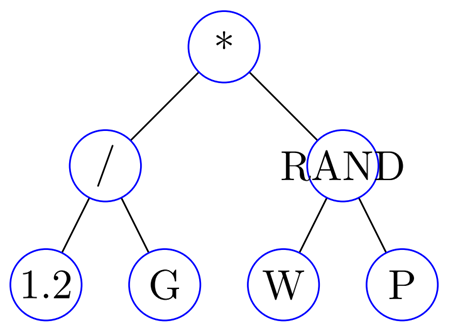

When represented in the prescribed output format we will discuss later, this example parse tree appears as follows:
```
*
|/
||1.2
||G
|RAND
||W
||P
```

## Implementing The Parse Tree Genotype
Recall that in this assignment, it is up to you to implement the parse tree gene representation as an open-ended problem. This assignment will focus on generating and executing trees, but keep in mind that the next assignment will have you recombine and mutate trees as well. Your implementation for this assignment should be able to create parse trees with the grow and full methods, print trees as strings using the prescribed output format, and execute parse trees to evaluate a state $s'$. The details of these requirements will be discussed momentarily. We informally suggest that you follow the remainder of this notebook in order, as we believe it to be the most logical order for most people. However, **this assignment is open-ended and you are encouraged to implement the required functionality in the order that makes the most sense *to you***. As such, you are welcome to complete sections of this notebook out of order so long as the notebook in your final submission runs from beginning to end.

**We strongly recommend that you implement your parse tree gene representation as a new class.** An object instance of your new class will later be assigned to the `genes` member variable of the provided `TreeGenotype` class. You are welcome to define your tree class in the `tree_genotype.py` file since your representation class could be tightly coupled with the provided `TreeGenotype` class. If you wish to define your class in a new file, however, please import your file in the following cell. To be clear, the `genes` variable will represent the entire parse tree, analogous to the linear genotype from Assignment Series 1.

In [175]:
from tree_genotype import *

### The Full Method for Tree Initialization
Assume we have a set of nonterminal primitives $F$, a set of terminal input primitives $T$, and an initial depth limit $D_{max}$. In the full method, **every branch of the tree has depth $D_{max}$**. That is, nodes at depth $d$ are chosen from $F$ if $d<D_{max}$ or from $T$ if $d=D_{max}$ [1]. Depth is calculated as the distance from the root, so the root has depth 0, its children have depth 1, their children have depth 2, etc.

In less formal terms, you create a tree by selecting random nonterminal nodes until you reach the depth limit. Once you reach the depth limit, you select random terminal nodes. This produces full trees where each branch reaches the depth limit.

**HINT**: These will be called from the `TreeGenotype.initialization` class method. If you pass that function `**config['pac_init']`, it will have `depth_limit` from your config, and it will have the `terminals` and `nonterminals` variables from your config inside of `kwargs`. Refer back to the parameter unpacking tutorial from Assignment 1b for more examples about this technique, which we used extensively in Assignment Series 1. You could use a similar technique (unpacking `kwargs`) to cleanly pass the `terminals` and `nonterminals` variables to your code for the full method.

Implement the full method in your .py file, then call it in the next cell to instantiate a tree. You can modify this cell to test your implementation however you wish.

In [176]:
config = read_config('configs/2a/green_config.txt', globals(), locals())
for depth in [1, 2, 3, 4, 5]:
    # Instantiate a tree with your full method using the given depth.
    config["pac_init"]["depth_limit"] = depth
    tree = full_method(0, **config["pac_init"])
    
del config, tree

### The Grow Method for Tree Initialization
Like the full method, assume we have a set of nonterminal primitives $F$, a set of terminal primitives $T$, and an initial depth limit $D_{max}$. In the grow method, however, nodes at depth $d$ are chosen from $F \cup T$ if $d<D_{max}$ or from $T$ if $d=D_{max}$ [1].

In less formal terms, you create a tree by randomly selecting a terminal *or* nonterminal node if under the depth limit. If at the depth limit, you select a random terminal node. This produces trees with less uniform branch depth than the full method since branches can terminate before the depth limit when a terminal node is selected.

**Note**: This algorithm will come in handy when you implement mutation in Assignment 2b, since you can use it to grow new branches/subtrees on an existing tree. Try to write your code with this plan in mind.

Implement the grow method in your .py file, then call it in the next cell to instantiate a tree. You can modify this cell to test your implementation however you wish.

In [177]:
config = read_config('configs/2a/green_config.txt', globals(), locals())
for depth in [1, 2, 3, 4, 5]:
    # Instantiate a tree with your grow method using the given depth.
    config["pac_init"]["depth_limit"] = depth
    tree = grow_method(0, **config["pac_init"])

del config, tree

### Population Initialization with Ramped Half-And-Half
Now that the grow and full methods are implemented, you have the necessary components to implement ramped half-and-half population initialization. In ramped half-and-half, half of the population is initialized with the grow method and the other half with the full method.

The population should be generated with max depths distributed uniformly across the range `[1, depth_limit]`. `depth_limit` is in the config, and you can increase it to allow for more complicated trees, though you should not lower it beneath the default value we have provided. In practice you would assign depths deterministically, but we consider it acceptable to sample uniform randomly from this range each time you generate a tree.

Implement the `initialization` class method of the `TreeGenotype` class in `tree_genotype.py` such that the `genes` member variable of each individual in the population is assigned a tree using the ramped half-and-half method.

Once implemented, execute the following cell to call your ramped half-and-half implementation.

In [178]:
config = read_config('configs/2a/green_config.txt', globals(), locals())
mu = 500
example_population = TreeGenotype.initialization(mu, **config['pac_init'])

if len(example_population) != mu:
    print('The population does not have the correct number of individuals.')
if any(individual.genes is None for individual in example_population):
    print('Some of the population had no genes assigned.')

del config, mu, example_population

### Serialization
As discussed in Assignment Series 1, serialization and deserialization are very important in EC for a number of reasons. When working with GP trees we have another important motivator in that it is tremendously valuable to visualize your trees and the equations/programs they encode. We require you to implement the `TreeGenotype.serialize` method to return a string representing `self.genes` with the following format. We gave an example of this format for a tree earlier in the notebook.

Nodes are listed starting from the root according to a depth-first pre-order traversal. Each node should be on its own line. The line should begin with a number of pipes (`|`) equal to the depth of the node, where the root has depth 0. The line then ends with the string representing the node. This could be written as:

`<a number of '|'s equal to the current depth><node string><newline>`

A `G` node at depth 3 would thus be printed as `|||G`.

The string representation for each primitive type is the same one that is provided in the default `green_config.txt` `terminals` and `nonterminals` variables (e.g., `'G'`, `'P'`, `'+'`, `'-'`, `'RAND'`, etc.), except for constant nodes which should be converted to a string using `str(float(value))`.

Refer back to the *GPac Parse Trees* section in this notebook, where we introduced the primitives, for an example of this format. That section also contains the expected names for the primitives, if you've changed the primitive representation in your config.

Once implemented, execute the following cell and manually inspect some small trees for obvious errors.

In [179]:
config = read_config('configs/2a/green_config.txt', globals(), locals())
config['pac_init']['depth_limit'] = 3
example_population = TreeGenotype.initialization(10, **config['pac_init'])

for idx, individual in enumerate(example_population):
    print(f"Individual {idx}'s tree:")
    print(individual.serialize())

del config, example_population

Individual 0's tree:
*
|+
||/
|||P
|||-19.289572700897285
||RAND
|||F
|||P
|-
||/
|||G
|||10.960111819762126
||+
|||F
|||F

Individual 1's tree:
+
|P
|G

Individual 2's tree:
+
|RAND
||+
|||-10.989722376069189
|||F
||-
|||0.37669386478965095
|||F
|-
||/
|||W
|||F
||*
|||F
|||P

Individual 3's tree:
/
|/
||RAND
|||W
|||G
||*
|||F
|||18.948540122079976
|*
||*
|||-23.238496923345163
|||F
||-
|||G
|||F

Individual 4's tree:
+
|/
||/
|||22.46369971549136
|||P
||RAND
|||P
|||F
|/
||/
|||W
|||P
||-
|||F
|||W

Individual 5's tree:
RAND
|P
|F

Individual 6's tree:
+
|/
||P
||F
|-
||-12.789533025490798
||F

Individual 7's tree:
P

Individual 8's tree:
/
|/
||W
||F
|/
||F
||W

Individual 9's tree:
P



### Automated Tree Assessment
Now that you've done some light manual testing, let's perform some automated testing at scale using a tool that examines trees from files. Execute the following cell to generate 100 trees that will be subjected to automated assessment. Note that this only checks for valid structure and printing, and doesn't necessarily guarantee that your tree generation or execution are entirely correct.

In [180]:
config = read_config('configs/2a/green_config.txt', globals(), locals())
example_population = TreeGenotype.initialization(100, **config['pac_init'])

os.makedirs('tree_tests/', exist_ok=True)
for idx, individual in enumerate(example_population):
    with open(f'tree_tests/tree{idx}.txt','w') as f:
        f.write(individual.serialize())

!python tree_check.py tree_tests/tree*.txt

del config, example_population

tree_tests/tree0.txt: PASS
tree_tests/tree1.txt: PASS
tree_tests/tree10.txt: PASS
tree_tests/tree11.txt: PASS
tree_tests/tree12.txt: PASS
tree_tests/tree13.txt: PASS
tree_tests/tree14.txt: PASS
tree_tests/tree15.txt: PASS
tree_tests/tree16.txt: PASS
tree_tests/tree17.txt: PASS
tree_tests/tree18.txt: PASS
tree_tests/tree19.txt: PASS
tree_tests/tree2.txt: PASS
tree_tests/tree20.txt: PASS
tree_tests/tree21.txt: PASS
tree_tests/tree22.txt: PASS
tree_tests/tree23.txt: PASS
tree_tests/tree24.txt: PASS
tree_tests/tree25.txt: PASS
tree_tests/tree26.txt: PASS
tree_tests/tree27.txt: PASS
tree_tests/tree28.txt: PASS
tree_tests/tree29.txt: PASS
tree_tests/tree3.txt: PASS
tree_tests/tree30.txt: PASS
tree_tests/tree31.txt: PASS
tree_tests/tree32.txt: PASS
tree_tests/tree33.txt: PASS
tree_tests/tree34.txt: PASS
tree_tests/tree35.txt: PASS
tree_tests/tree36.txt: PASS
tree_tests/tree37.txt: PASS
tree_tests/tree38.txt: PASS
tree_tests/tree39.txt: PASS
tree_tests/tree4.txt: PASS
tree_tests/tree40.txt: PA

### Deserialization
With your serialization working correctly (hopefully), you can begin working on deserialization in the `TreeGenotype.deserialize` method. We have provided a lot of the logic of this method for you, parsing the string in order to determine where nodes belong in the deserialized tree, and your only job is to create the individual nodes and piece them together into your chosen data structure.

After finishing that implementation, run the following cell to check that your code is correctly recreating parse trees.

In [181]:
config = read_config('configs/2a/green_config.txt', globals(), locals())
config['pac_init']['depth_limit'] = 3
example_population = TreeGenotype.initialization(5, **config['pac_init'])

for idx, individual in enumerate(example_population):
    # Serialize a random tree
    serialization = individual.serialize()

    # Deserialize to reconstruct the tree as a new TreeGenotype
    deserialized = TreeGenotype()
    deserialized.deserialize(serialization)
    reserialization = deserialized.serialize()

    if serialization == reserialization:
        print(f'Tree {idx} was deserialized correctly!')
    else:
        print(f'Tree {idx} was NOT deserialized correctly!')
        print(f'Initial tree:\n{serialization}')
        print(f'Deserialized tree:\n{reserialization}')

del config, example_population

Tree 0 was deserialized correctly!
Tree 1 was deserialized correctly!
Tree 2 was deserialized correctly!
Tree 3 was deserialized correctly!
Tree 4 was deserialized correctly!


## Fitness Evaluation
In this assignment, we're leaving part of the fitness function for you to implement as you need to interface your custom tree genotype implementation. In Assignment 2c, we'll be performing competitive co-evolution with multiple controllers. For assignments 2a and 2b though, your Pac-Man agents will play against ghost agents that select random moves.

### State Dictionaries
The interface between your parse tree and the game is through a list of state dictionaries. This list represents the space of valid $s'$ states resulting from Pac-Man's possible actions. Each $s'$ state is represented by one of the state dictionaries. The state dictionaries contain all the information about the game necessary for your parse tree's sensor inputs. Execute the following cell to see an example of what a state dictionary looks like.

In [182]:
from gpac import GPacGame
from fitness import parse_map

config = read_config('configs/2a/green_config.txt', globals(), locals())

# Ignore these next 2 lines; this is not code you will ever be using in practice.
game_map = parse_map(config['game']['game_map'])
game = GPacGame(game_map)

# The following lines are the focus of this demo.
actions = game.get_actions()
s_primes = game.get_observations(actions)
for k, v in s_primes[0].items():
    if not isinstance(v, tuple):
        print("{}: {}".format(k, v))

walls = s_primes[0]['walls']
print('walls:')
for y in range(1, len(walls[0]) + 1):
    for x in range(len(walls)):
        if walls[x][-y]:
            print('#', end='')
        else:
            print('~', end='')
    print()

del game_map, game, actions, s_primes, walls

pills: frozenset({(12, 16), (23, 13), (30, 6), (3, 13), (17, 6), (8, 15), (24, 11), (25, 4), (2, 8), (32, 15), (15, 11), (29, 4), (29, 13), (23, 9), (22, 7), (34, 3), (5, 6), (28, 11), (3, 15), (9, 4), (5, 15), (25, 9), (1, 11), (15, 4), (11, 19), (15, 7), (25, 15), (31, 6), (7, 15), (34, 5), (34, 8), (14, 11), (4, 13), (33, 0), (8, 13), (19, 13), (10, 19), (26, 9), (13, 15), (18, 14)})
fruit: None
players: {'m': (0, 19), '0': (34, 0), '1': (0, 0), '2': (34, 19)}
walls:
~~~~~~~~~~~~~~~~~#~~~~~~~~~~~~~~~~~
~######~########~#~########~######~
~#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#~
~#~#########~###~#~###~#########~#~
~~~~~~~~~~~~~~~~~#~~~~~~~~~~~~~~~~~
~#~#####~#######~~~#######~#####~#~
~#~~~~~~~~~~~~~~~#~~~~~~~~~~~~~~~#~
~#~########~#~#######~#~########~#~
~~~~~~~~~~~~#~~~~~~~~~#~~~~~~~~~~~~
###~##~####~#~###~###~#~####~##~###
###~##~~~~~~#~~~~~~~~~#~~~~~~##~###
~~~~~~~####~#~#######~#~####~~~~~~~
~##~#####~~~~~~~~~~~~~~~~~#####~##~
~##~~~~~~~#######~#######~~~~~~~##~
~####~###~~~~~###~###

**Notes**:
* The above cell prints the walls using `#` and `~`, to make the map easier to read. In the code, however, walls are represented with `True` or `False`, with `walls[x][y]` being `True` if there is a wall in cell `(x, y)`, or `False` if there is not.
* `fruit` will be an `(x, y)` tuple if there is a fruit on the map, or `None` if there is not a fruit.
* To determine if a player is Pac-Man (rather than a ghost), you should use `'m' in player`. There will be bonuses in future assignments that involve having multiple Pac-Man agents; in that case, their names will be `'m0'`, `'m1'`, `'m2'`, etc.

### Tree Execution
Regardless of how you've implemented your trees so far, they must accept as input a state dictionary and return as output a floating-point number representing the tree's score for that state. Using this score, you will select the index of the action with the best score as determined by the greedy policy mentioned earlier in this notebook.

In whatever order you like, implement your tree execution functionality and the portion of `play_GPac` in `fitness.py` where you use your genotype to score states and select an action. The `play_GPac` function expects as input a `pac_controller` object in addition to other parameters in your config file. The object you pass in for the controller could either be a `TreeGenotype` object with an initialized `genes` member variable, or the genotype's `genes` member object itself.

The implementation of tree execution and the fitness function is relatively open-ended and thus you may test the execution of your parse trees however you see fit. If you're feeling lost though, feel free to reference the Pac-Man GP Tree Implementation presentation given in class for some pseudocode and guidance. The easiest way to test your tree execution is most likely to implement a single-node tree for each of your terminal primitives and then perform a fitness evaluation using those before moving on to deeper trees.

We softly recommend that you cache the values from your terminal primitives during the evaluation of a given state. That is, a tree might have ten different `P` nodes in it, but these will all have the same value for the same state; running the full calculation ten separate times for every state is unnecessary. Caching this value in an intelligent and efficient way can dramatically reduce runtimes, but you have to carefully consider how you approach this to ensure it isn't causing incorrect behavior.

**Note**: In addition to the execution method shown in class, GP can also be implemented by assigning the chosen function to a member variable of the nodes, as Python allows you to use functions just like any other variable. This might be an advanced technique, but feel free to look closer at how the survival selection function was called in the Assignment Series 1 EA object class for an example of what this could look like.

Using the following cell, assign to `pac_controller` an object appropriate for your `play_GPac` implementation to play a full game. You are welcome to add additional tests to the following cell as well.

In [183]:
config = read_config('configs/2a/green_config.txt', globals(), locals())

# Assign your controller to this variable.
pac_controller = TreeGenotype.initialization(1, **config['pac_init'])[0]

# You should use a similar function call in your search algorithm code.
score, log = play_GPac(pac_controller, **config['game'])

# Logging the game for use with the visualizer.
game_log_path = 'test_game.txt'
with open(game_log_path, 'w') as f:
    [f.write(f'{line}\n') for line in log]

# Print for tutorialization.
print(f"Pac-Man's score was {score}, and the game log was written to {game_log_path}")

del config, pac_controller, score, log, game_log_path

Pac-Man's score was 21.122923588039868, and the game log was written to test_game.txt


## Random Search Algorithm
By this point, your implementation of tree initialization, tree printing, tree execution, and the fitness function should be complete. In the following cell, implement a function to conduct a single run of random GP search by evaluating a population of `num_evaluations` solutions.

Beyond just implementing random search, there are five data collection tasks for this function:

1. Call `hist.add(score)` once per evaluation
2. Return the highest-scoring `TreeGenotype` as `best_solution`
3. Return the score this best solution received as `best_score`
4. Return the log from the game that produced this best score as `best_log`
5. Return appropriate data for generating an evals-vs-best-score stairstep plot as `stairstep_data`
    * This is identical to the requirement from Assignment 1a


**Note**: The game logs can consume a very large amount of memory, especially if you plan on multiprocessing your experiment. We recommend you write your random search in such a way that only the current-best game log is stored in memory at any given time. If you attempt to run `num_evaluations` games before determining which game's log you need to keep, you may run out of RAM. This is especially relevant if you want to fully leverage multiprocessing during the multi-run experiment portion of this assignment.

In [184]:
from math import inf

def random_search_run(num_evaluations, config):
    # Initialize a RoundedFitnessHistogramMaker
    hist = RoundedFitnessHistogramMaker()

    # Assign your best score to this variable
    # Starting at -inf is a good way to keep track of the best score
    best_score = -inf

    # Assign your best TreeGenotype to this variable
    best_solution = None

    # Assign the log from the highest-scoring game to this variable
    best_log = None

    # Assign your stairstep data to this variable
    # It's up to you to figure out what that data should be!
    stairstep_data = []

    # TODO: Conduct your random search here

    # We iterate num_evalutations times for our random search
    for _ in range(num_evaluations):

        # We initialize our solution
        pac_controller = TreeGenotype.initialization(1, **config['pac_init'])[0]

        # Find the score and log of the controller
        score, log = play_GPac(pac_controller, **config['game'])

        # We save the fitness of our solution into our solution object
        pac_controller.fitness = score

        # We change the best_score, best_solution, and best_log if the fitness of our current controller is greater than the current best_score
        if pac_controller.fitness > best_score:
            best_score = pac_controller.fitness
            best_solution = pac_controller
            best_log = log

        # Add the fitness of the contoller to the HistogramMaker
        hist.add(pac_controller.fitness)

        # We append the max fitness after this evaluation into the stairstep_data array
        stairstep_data.append(best_score)
    
    return best_solution, best_score, best_log, stairstep_data, hist

Now run the next cell to test your function. This may take a minute or two to run. **If you ever change the function in the previous cell, make sure to execute that cell again so the changes get loaded by the interpreter!** Otherwise, the changes won't take effect in other cells.

Best solution looks like:
RAND
|G
|0.9971682953508463

Best score: 50.310077519379846
Histogram:


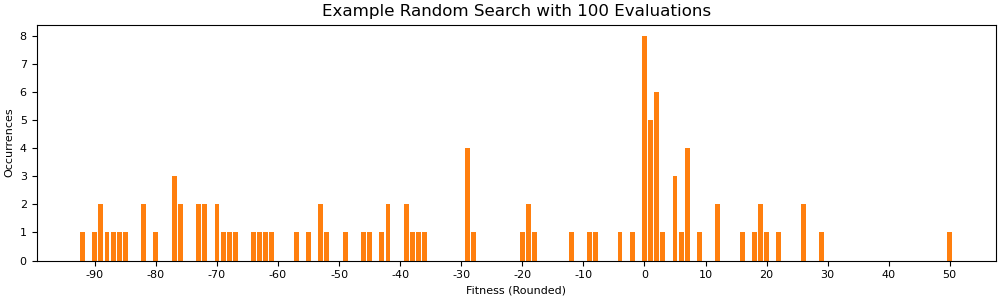

Stairstep data:
[-92.1811738648948, -76.05714285714286, 1.011295681063123, 7.302325581395349, 15.503875968992247, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.581395348

In [185]:
config = read_config('configs/2a/green_config.txt', globals(), locals())
num_evaluations = 100 # Smaller eval count to make this test quicker

# Call your function
(
    best_solution,
    best_score,
    best_log,
    stairstep_data,
    hist
) = random_search_run(num_evaluations, config)

print('Best solution looks like:')
print(best_solution.serialize())
print('Best score:', best_score)

print('Histogram:')
hist.get_plot(f'Example Random Search with {num_evaluations} Evaluations').show()

print('Stairstep data:')
print(stairstep_data)

del config, num_evaluations, best_solution, best_score, best_log, stairstep_data, hist

## Full Random Search Experiment
Now, write the code for conducting a multi-run experiment in the following cell. For data collection, you need to return five things from this function:

1. The highest score encountered in each run (one number per run) as `best_per_run`
2. The highest-scoring `TreeGenotype` found by any of the runs as `best_solution`
3. The log from the highest-score game found by any of the runs as `best_log`
4. The `stairstep_data` from the run which produced the best solution
5. The `RoundedFitnessHistogramMaker` representing the data collected from the runs (**this is already done for you!**)

As with the previous assignments, there are two important things to note about this cell. First, **any time you change a `.py` file, you need to re-execute the following cell** to avoid pickling errors. Second, if you run out of RAM (which typically manifests as your program no longer utilizing the CPU, even though it *looks* like it's still running), you need to pass `processes=x` to the `multiprocessing.Pool` call in order to limit the number of runs that execute in parallel.

In [186]:
from tree_genotype import TreeGenotype
from fitness import play_GPac

# Returning a TreeGenotype object can cause pickling issues depending on your implementation.
# This just calls your random search run function, and serializes the best solution.
# We instead return this serialized string and the other data, sidestepping the issue.
def multiprocess_helper(num_evaluations, config):
    (
        best_solution,
        best_score,
        best_log,
        stairstep_data,
        hist
    ) = random_search_run(num_evaluations, config)
    return best_solution.serialize(), best_score, best_log, stairstep_data, hist


def random_search_experiment(num_runs, num_evaluations, config):
    # We handle this for you; don't worry about the histograms here
    hist_per_run = []

    # Assign the highest score seen in each run to this variable
    # i.e., a list/tuple of num_runs numbers
    best_per_run = []
    
    # Assign your best TreeGenotype to this variable
    # It should be the highest-scoring solution seen across all runs
    best_solution = None

    # Assign the log from the highest-scoring game to this variable
    best_log = None

    # Assign the stairstep data from your best run to this variable
    # That is, this is stairstep_data from the same run as best_solution
    stairstep_data = None
    
    # This executes your runs in parallel, using the multiprocess_helper function
    # IMPORTANT: If you are running out of RAM, as mentioned in the above text,
    # you can pass 'processes' keyword argument to multiprocessing.Pool() here
    with multiprocessing.Pool() as pool:
        args = [(num_evaluations, config)] * num_runs
        run_results = list(pool.starmap(multiprocess_helper, args))

    best_score = -inf

    # Iterate over the completed runs' results
    for i in range(num_runs):
        # This gets the data from run i,
        # deserializes its best solution as run_best_solution,
        # and collects the histogram (don't worry about the histogram)
        run_serialization, run_best_score, run_best_log, run_stairstep_data, hist = run_results[i]
        run_best_solution = TreeGenotype()
        run_best_solution.deserialize(run_serialization)
        hist_per_run.append(hist)

        # TODO: Use run_best_solution, run_best_score,
        #       run_best_log, and run_stairstep_data
        #       to collect data in the variables described at
        #       the start of this function

        best_per_run.append(run_best_score)

        if run_best_score > best_score:
            best_solution = run_best_solution
            best_score = run_best_score
            best_log = run_best_log
            stairstep_data = run_stairstep_data
            
    # Merge the histograms into one single histogram
    merged_hist = RoundedFitnessHistogramMaker.merge(hist_per_run)

    return best_per_run, best_solution, best_log, stairstep_data, merged_hist

Let's run a quick test in the next cell to make sure everything works, before we embark on a full experiment. As a reminder, **if you change the previous cell, make sure to re-run that cell to save the changes to your function!** We'll do 3 runs of 1,000 evaluations each:

Correct number of best fitnesses? True
Best fitness per run: [52.713178294573645, 64.96124031007753, 78.21705426356588]
Best solution looks like:
RAND
|+
||-
|||*
||||+
|||||RAND
||||||7.395180812498985
||||||W
|||||+
||||||F
||||||P
||||-
|||||/
||||||G
||||||P
|||||/
||||||P
||||||F
|||RAND
||||/
|||||*
||||||-11.032036932378226
||||||F
|||||-
||||||16.335563565776575
||||||G
||||*
|||||-
||||||P
||||||21.97157223110777
|||||RAND
||||||21.621759002085106
||||||F
||-
|||/
||||-
|||||/
||||||F
||||||F
|||||*
||||||P
||||||F
||||+
|||||+
||||||P
||||||G
|||||RAND
||||||-4.384549953398853
||||||F
|||+
||||/
|||||RAND
||||||F
||||||17.398867019037233
|||||RAND
||||||F
||||||W
||||/
|||||/
||||||G
||||||G
|||||RAND
||||||G
||||||G
|-
||RAND
|||+
||||+
|||||*
||||||G
||||||W
|||||-
||||||W
||||||P
||||/
|||||RAND
||||||W
||||||7.617197333931067
|||||-
||||||F
||||||G
|||+
||||+
|||||-
||||||G
||||||P
|||||+
||||||W
||||||W
||||RAND
|||||-
||||||W
||||||P
|||||-
||||||P
||||||G
||-
|||*
||||

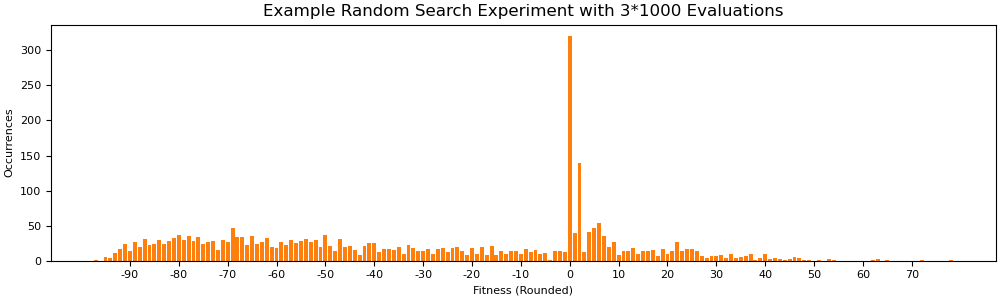

Stairstep data:
[23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 23.953488372093023, 24.031007751937985, 24.031007751937985, 24.031007751937985, 24.031007751937985, 24.031007751937985, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 24.8062015503876, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883721, 25.58139534883

In [187]:
example_num_runs = 3
example_num_evaluations = 1_000
config = read_config('configs/2a/green_config.txt', globals(), locals())

(
    example_best_per_run,
    example_best_solution,
    example_best_log,
    example_stairstep_data,
    example_hist
) = random_search_experiment(example_num_runs,
                             example_num_evaluations,
                             config)

print('Correct number of best fitnesses?', example_num_runs == len(example_best_per_run))

print('Best fitness per run:', example_best_per_run)
print('Best solution looks like:')
print(example_best_solution.serialize())

print('Histogram:')
example_hist_plot = example_hist.get_plot('Example Random Search Experiment with ' +\
                                          f'{example_num_runs}*{example_num_evaluations} Evaluations')
example_hist_plot.show()

print('Stairstep data:')
print(example_stairstep_data)

As in previous assignments, the following cell defines a function that saves your results in a permanent format for later analysis.

In [188]:
def save_data(best_per_run, best_solution, best_log, stairstep_data, hist, subdir, config):
    subdir.mkdir(parents=True, exist_ok=True)
    
    with open(subdir / 'best_per_run.txt', 'w') as f:
        for result in best_per_run:
            f.write(str(result) + '\n')

    with open(subdir / 'best_solution.txt', 'w') as f:
        f.write(best_solution.serialize())

    with open(subdir / 'best_log.txt', 'w') as f:
        for line in best_log:
            f.write(str(line) + '\n')

    with open(subdir / 'stairstep.txt', 'w') as f:
        f.write(str(stairstep_data))
    
    hist.save_to_file(subdir / 'histogram.txt')

    print('Data saved to', subdir)

Now run the next cell to save the results of our test experiment!

In [189]:
save_data(example_best_per_run,
          example_best_solution,
          example_best_log,
          example_stairstep_data,
          example_hist,
          Path('./data/2a/example/'),
          config)
example_hist_plot.savefig('data/2a/example/histogram.png')

Data saved to data/2a/example


Outside of this notebook, navigate to `./data/2a/example/` and take a look at what was saved. Make sure everything is there, and the data matches what we printed above.

If everything works as expected, run the following cell to run your full experiment and save the data! Note this may take a while, as we are generating and testing quite a few solutions.

Data saved to data/2a/green


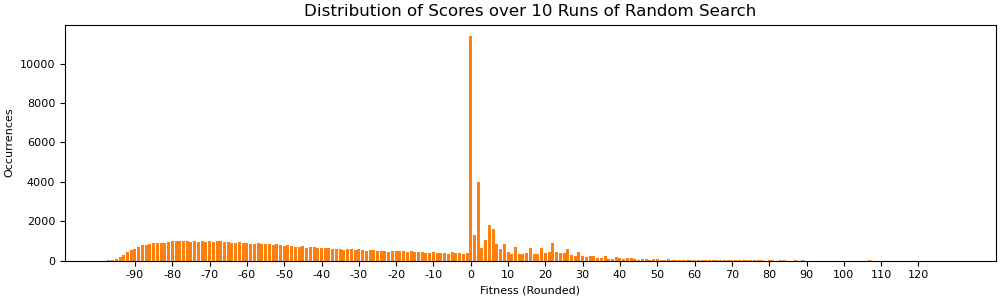

In [190]:
num_runs = 10
num_evaluations = 10_000
config = read_config('configs/2a/green_config.txt', globals(), locals())

(
    best_per_run,
    best_solution,
    best_log,
    stairstep_data,
    hist
) = random_search_experiment(num_runs,
                             num_evaluations,
                             config)

save_data(best_per_run,
          best_solution,
          best_log,
          stairstep_data,
          hist,
          Path('./data/2a/green/'),
          config)

fig = hist.get_plot(f'Distribution of Scores over {num_runs} Runs of Random Search')
fig.savefig('data/2a/green/histogram.png')
fig.show()

# Preparing the Report
Now that you've completed the implementation of random search, you need to use the data you've generated to create the report requested in the assignment description document. This report requires a histogram, which has already been made for you, as well as a stairstep plot, which we will walk through here, comments about the best game, which we will visualize for you, and some metrics based on the best scores.

## Stairstep Plot
Just as in Assignment 1a, the data used for your plot should demonstrate the search progress of the run that produced the highest score. The x-axis should be the number of evaluations, and the y-axis should be score. The plotted value is the highest score seen so far during the run.

In the following cell, finish implementing the function which will generate your stairstep plot. All you need to do is write code that transforms `my_data` (which will be whatever data your experiment function returned) into `figure_y_values`, the y-values for the stairstep plot. Depending on how you collected data, this transformation may not even require any work at all. You are also free to rewrite this function's internal logic, if using `ax.step` or `ax.stairs` is simpler for your use-case (note this may require changing the way `figure_x_values` is calculated).

In [191]:
def make_stairstep(my_data, title, filename):
    # Set this to the appropriate y values
    # That is, the y-value that should be displayed, one per evaluation
    figure_y_values = my_data

    
    
    # x values are 1..num_evaluations if using ax.plot
    # You *probably* don't need to change this
    figure_x_values = [i + 1 for i in range(len(figure_y_values))]
    
    # This will plot the above x and y values for you
    fig, ax = plt.subplots()
    ax.plot(figure_x_values, figure_y_values)
    ax.set(xlabel='Evaluations', ylabel='Score', title=title)
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.savefig(filename)

With that function completed, run the following cell to generate your stairstep plot! We'll save it to `data/2a/green/stairstep.png`, as well as display it. Don't forget to put it in your report!

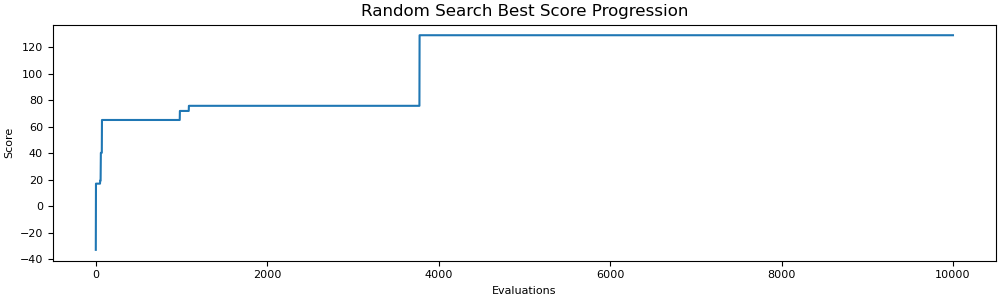

In [192]:
make_stairstep(stairstep_data,
               'Random Search Best Score Progression',
               'data/2a/green/stairstep.png')

## Visualization
Simply run the following cell to get a visualization! This will be displayed in your notebook, and it will also be saved to your data directory. Note this may take several minutes.

In [ ]:
animation = render_game(best_log)

with open('data/2a/green/visualization.html', 'w') as f:
    f.write(animation)

display(HTML(animation))

You do not need to include the visualization itself in your report (though it does need to be in your data directory). We do, however, ask that you watch the game and provide a few qualitative comments about it in your report.

## Best Scores
In the following cell, write code to calculate the mean and standard deviation of the best score found in each run. Put these in your report.

In [197]:
# TODO: Calculate mean and standard deviation of your best score from each run here
mean = statistics.mean(best_per_run)
std = statistics.stdev(best_per_run)

print("Mean: ", mean)
print("Standard Deviation: ", std)

Mean:  114.25413067552603
Standard Deviation:  13.366695919511455


# Red 1 Deliverable (Bonus)
If attempting the Assignment 2a RED 1 deliverable, perform your experiment and analysis below. You may add new cells, if you wish. Note you should change your fitness function call to `play_GPac` to have `None` as the first argument, and your ghost controller as the second argument, i.e. `play_GPac(None, ghost_controller, **config['game'])`.

# Red 2 Deliverable (Bonus)
If attempting the Assignemt 2a RED 2 deliverable, perform your experiment and analysis below. You may add new cells, if you wish.

## References
[1] A. E. Eiben and J. E. Smith, Introduction to Evolutionary Computing. Second Edition, Springer-Verlag,
Berlin Heidelberg, 2015, ISBN 978-3-662-44873-1